# Kaggle API setup to upload data set.

In [1]:
# installing kaggle
!pip install -q kaggle

# upload your kaggle api key

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\n  "username": "edwynestrada",\n  "key": "KGAT_98dec044f84899dcd1b1e95cbc3d1ad2"\n}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
import os
os.makedirs("/content/cecs456_project", exist_ok=True)
%cd /content/cecs456_project

/content/cecs456_project


In [5]:
# downloads zip file from kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 14% 329M/2.29G [00:00<00:01, 1.72GB/s]Downloading chest-xray-pneumonia.zip to /content/cecs456_project
 98% 2.24G/2.29G [00:08<00:00, 573MB/s]
100% 2.29G/2.29G [00:08<00:00, 286MB/s]
 98% 2.24G/2.29G [00:08<00:00, 573MB/s]
100% 2.29G/2.29G [00:08<00:00, 286MB/s]


In [6]:
# unzip zip file with images into folder
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# Possible Issue and fix for duplicating files
** Note ** <br>
When unziping files, there is a possibility that some of the files will duplicate. If that occurs, run these command(s) (which ever applies)<br>
!rm -rf /content/cecs456_project/chest_xray/__MACOSX <br>
!rm -rf /content/cecs456_project/chest_xray/chest_xray <br>
in the following cells to remove them.

In [7]:
# removes meta folder
!rm -rf /content/cecs456_project/chest_xray/__MACOSX
print("_MACOSX folder removed")

_MACOSX folder removed


In [8]:
# removes nested duplicate chest_xray folder
!rm -rf /content/cecs456_project/chest_xray/chest_xray
print("Nested chest_xray folder removed")

Nested chest_xray folder removed


# Setup

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
np.random.seed(42)
import matplotlib.pyplot as plt
tf.random.set_seed(42)

# Loading the Dataset

In [10]:
# setting up the paths to the datasets
training_set = os.path.join('/content/cecs456_project/chest_xray', 'train')
testing_set = os.path.join('/content/cecs456_project/chest_xray', 'test')

# resizes images to a lower scale
IMG_HEIGHT = 180
IMG_WIDTH = 180
# number of images processed at a time
BATCH_SIZE = 16
# uses 20% of the training data for validation
VALIDATION_SPLIT = 0.2
# ensures reproducability of training and validation splits
SEED = 42

In [11]:
# scans folder and counts files to store file path
# creating file paths and instructions to how to resize and preprocess the images
# the traing will take 80% of the training set, validating will take the other 20%, and testing will test from the testing set

# training pathway
training_images = tf.keras.preprocessing.image_dataset_from_directory(training_set, validation_split = VALIDATION_SPLIT, subset = "training", seed = SEED, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = BATCH_SIZE, label_mode = "binary", shuffle = True)
# validating pathway
validating_images = tf.keras.preprocessing.image_dataset_from_directory(training_set, validation_split = VALIDATION_SPLIT, subset = "validation", seed = SEED, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = BATCH_SIZE, label_mode = "binary", shuffle = True)
# testing pathway
testing_images = tf.keras.preprocessing.image_dataset_from_directory(testing_set, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = BATCH_SIZE, label_mode = "binary", shuffle = False)


Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [12]:
print(f"Training will be done in {tf.data.experimental.cardinality(training_images).numpy()} batches of {BATCH_SIZE} images.")
print(f"Validation will be done in {tf.data.experimental.cardinality(validating_images).numpy()} batches of {BATCH_SIZE} images.")
print(f"Testing will be done in {tf.data.experimental.cardinality(testing_images).numpy()} batches of {BATCH_SIZE} images.")

Training will be done in 261 batches of 16 images.
Validation will be done in 66 batches of 16 images.
Testing will be done in 39 batches of 16 images.


# Building the CNN

In [21]:
# initializes model
cnn_model = keras.Sequential(name = "cnn_model")

# rescales pixels to [0,1]
cnn_model.add(layers.Rescaling(1.0/255, input_shape =(IMG_HEIGHT, IMG_WIDTH, 3)))

# implements 4 convolutional blocks with 2 layers each

# first block for feature extraction with 32 filters
cnn_model.add(layers.Conv2D(32, 3, padding = "same", use_bias = False))
cnn_model.add(layers.BatchNormalization()) #
cnn_model.add(layers.Activation('relu'))
cnn_model.add(layers.Conv2D(32, 3, padding = "same", use_bias = False))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Activation('relu'))
cnn_model.add(layers.MaxPool2D(2))

# second block with 64 filters
cnn_model.add(layers.Conv2D(64, 3, padding = "same", use_bias = False))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Activation('relu'))
cnn_model.add(layers.Conv2D(64, 3, padding = "same", use_bias = False))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Activation('relu'))
cnn_model.add(layers.MaxPool2D(2))

# third block with 128
cnn_model.add(layers.Conv2D(128, 3, padding = "same", use_bias = False))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Activation('relu'))
cnn_model.add(layers.Conv2D(128, 3, padding = "same", use_bias = False))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Activation('relu'))
cnn_model.add(layers.MaxPool2D(2))

# fourth block with 256
cnn_model.add(layers.Conv2D(256, 3, padding = "same", use_bias = False))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Activation('relu'))
cnn_model.add(layers.Conv2D(256, 3, padding = "same", use_bias = False))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Activation('relu'))
cnn_model.add(layers.MaxPool2D(2))

# features flatten into 1D vector for classification
cnn_model.add(layers.Flatten())

# FC layer 1
cnn_model.add(layers.Dense(128, use_bias=False)) # changes from 128
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Activation("relu"))
cnn_model.add(layers.Dropout(0.3))

# FC layer 2
cnn_model.add(layers.Dense(32, use_bias=False)) # changed from 32
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Activation("relu"))
cnn_model.add(layers.Dropout(0.3))

# output layer
cnn_model.add(layers.Dense(1, activation = "sigmoid"))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
# displays model summary
cnn_model.summary()

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 180, 180, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 90, 90, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 90, 90, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             

 Total params: 5,144,833 (19.63 MB)

 Trainable params: 5,142,593 (19.62 MB)

 Non-trainable params: 2,240 (8.75 KB)

# Compiling the CNN model

In [23]:
# compiles model
# sets up the optimizer and loss function

cnn_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
print("Model compiled")

Model compiled


# Training the CNN Model

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
import time # to use timer to see how long model takes

print("Training has started")
print(f"Total Epochs: 20")
print(f"Batches size: {BATCH_SIZE}")
#
print(f"Training batches: {tf.data.experimental.cardinality(training_images).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(validating_images).numpy()}")
#
start_time = time.time() # timer begins

# implementing early stopping to prevent overfitting.
# early stopping will happen if there is no improvement after n epochs (implemented)
stop_early = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True, verbose = 1)
history = cnn_model.fit(training_images, validation_data = validating_images, epochs = 20, callbacks= [stop_early] , verbose = 1)

# without implementing early stopping (not implemented)
#history = cnn_model.fit(training_images, validation_data = validating_images, epochs = 20, verbose = 1)

end_time = time.time() - start_time # total training time

print("Done!")
print(f"Total training time was: {int(end_time//60)} mins and {int(end_time%60)} seconds.")



Training has started
Total Epochs: 20
Batches size: 16
Training batches: 261
Validation batches: 66
Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.8894 - loss: 0.2953 - val_accuracy: 0.7613 - val_loss: 1.2693
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9472 - loss: 0.1475 - val_accuracy: 0.9492 - val_loss: 0.1304
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9605 - loss: 0.1180 - val_accuracy: 0.9319 - val_loss: 0.1819
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9742 - loss: 0.0857 - val_accuracy: 0.9732 - val_loss: 0.0731
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9643 - loss: 0.0933 - val_accuracy: 0.9156 - val_loss: 0.2219
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9744 - loss: 0.0673 - val_accuracy: 0.7910 - val_loss: 0.4517
Epoch 7/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9823 - loss: 0.0565 - val_accuracy: 0.8322 - val_los

# Training and Validation Graphs

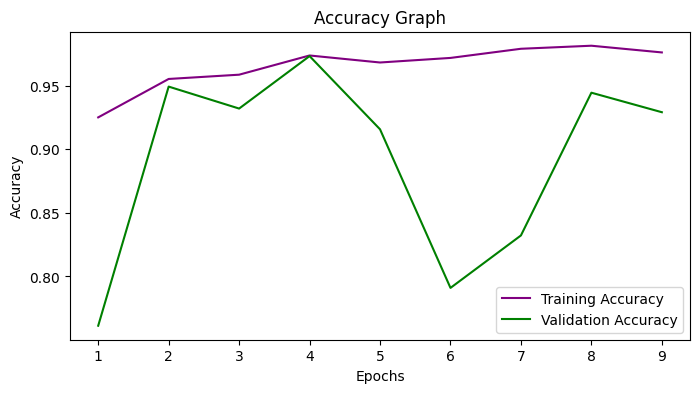


Final: 
Training Accuracy: 0.976 
Validation Accuracy: 0.929



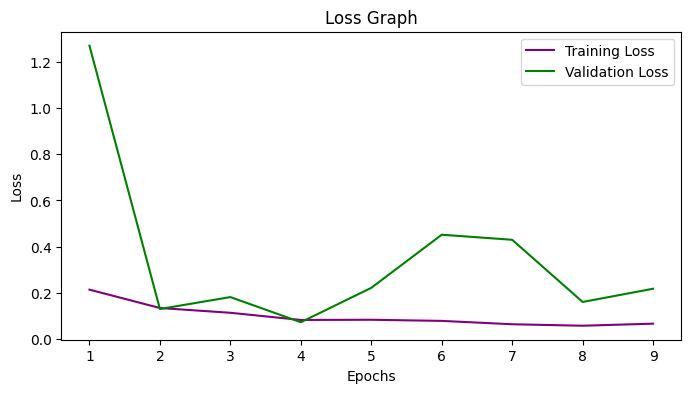


Final: 
Training Loss: 0.067 
Validation Loss: 0.218



In [25]:
#
accuracy = history.history["accuracy"]
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(accuracy) +1)

# ploting accuracy
plt.figure(figsize = (8,4))
plt.plot(epochs, accuracy, label = "Training Accuracy", color = "purple")
plt.plot(epochs, validation_accuracy, label = "Validation Accuracy", color = "green")
plt.title("Accuracy Graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show() # prints accuracy graph
print(f"\nFinal: \nTraining Accuracy: {accuracy[-1]:.3f} \nValidation Accuracy: {validation_accuracy[-1]:.3f}\n")

# plotting loss
plt.figure(figsize = (8,4))
plt.plot(epochs, loss, label = "Training Loss", color = "purple")
plt.plot(epochs, validation_loss, label = "Validation Loss", color = "green")
plt.title("Loss Graph")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
print(f"\nFinal: \nTraining Loss: {loss[-1]:.3f} \nValidation Loss: {validation_loss[-1]:.3f}\n")


# Evaluation

In [26]:
testing_loss, testing_accuracy = cnn_model.evaluate(testing_images, verbose = 1)
print(f"Total loss on Testing Set {testing_loss:.4f}")
print(f"Accuracy of Testing Set {testing_accuracy:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6463 - loss: 1.2154
Total loss on Testing Set 0.7369
Accuracy of Testing Set 0.7933


# Predictions on the first 9 images

In [53]:
# grabs the first 9 images
for xray_images, image_labels in testing_images.take(1):
  first9_imgs = xray_images[:9]
  first9_labls = image_labels[:9]
  break

class_name = ["NORMAL", "PNEUMONIA"]

print("Prediction Probabilites Results of the first 9 images")
# gets and prints the prediction probabilities
prediction_prob = cnn_model.predict(first9_imgs).flatten()
print(prediction_prob)

print("\nPrediction Results of the first 9 images")
# predicts and prints the class type (label)
prediction_class_type = (prediction_prob > 0.5).astype(int).flatten()
print(np.array(class_name)[prediction_class_type])

print("\nReal Labels")
# prints the real class type (label)
print(np.array(class_name)[first9_labls.numpy().astype(int).flatten()])

Prediction Probabilites Results of the first 9 images
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[0.01975781 0.86264956 0.18938357 0.91997063 0.04255925 0.02403529
 0.00981069 0.5442286  0.15984026]

Prediction Results of the first 9 images
['NORMAL' 'PNEUMONIA' 'NORMAL' 'PNEUMONIA' 'NORMAL' 'NORMAL' 'NORMAL'
 'PNEUMONIA' 'NORMAL']

Real Labels
['NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL'
 'NORMAL']


# Confusion Matrix and Classificaiton



In [102]:
from sklearn.metrics import confusion_matrix, classification_report

# grabs the predictions of the xray images
predicted_probabilites_of_xrays = cnn_model.predict(testing_images)
predicted_classes_of_xrays = (predicted_probabilites_of_xrays > 0.5).astype(int).flatten()
# grabs the actual real labels from the testing folder set
real_classes = np.concatenate([y for x, y in testing_images], axis = 0).astype(int)

print(f"Total number of Images: {len(real_classes)}")
print(f"Total NORMAL Images: {np.sum(real_classes == 0)}")
print(f"Total PNUEMONIA Images: {np.sum(real_classes == 1)}")

# Confusion Matrix
confus_matrix = confusion_matrix(real_classes, predicted_classes_of_xrays)

print("\n Confusion Matrix")
print("                      Predictions\n")
print("                    NORMAL PNEUMONIA")
print("                  ------------------")
print(f"           NORMAL |{confus_matrix[0,0]:4d}  | {confus_matrix[0,1]:4d}")
print("Actual            ------------------")
print(f"        PNEUMONIA |{confus_matrix[1,0]:4d}  | {confus_matrix[1,1]:4d}")
# Classificatin report. shows precision, recall, f1 score
print(f"\n\n{classification_report(real_classes, predicted_classes_of_xrays, target_names = ["NORMAL", "PNEUMONIA"])}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Total number of Images: 624
Total NORMAL Images: 234
Total PNUEMONIA Images: 390

 Confusion Matrix
                      Predictions

                    NORMAL PNEUMONIA
                  ------------------
           NORMAL | 109  |  125
Actual            ------------------
        PNEUMONIA |   4  |  386


              precision    recall  f1-score   support

      NORMAL       0.96      0.47      0.63       234
   PNEUMONIA       0.76      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.86      0.73      0.74       624
weighted avg       0.83      0.79      0.77       624



# Visual Model Predictions

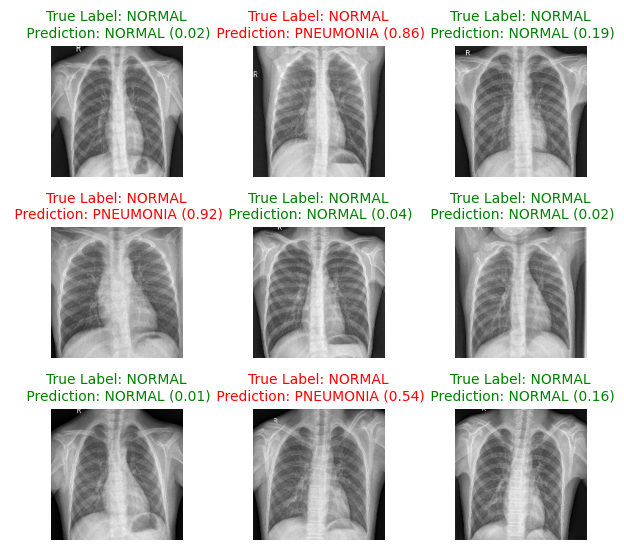

In [126]:
# visual comparison of predictions vs actual
# displays first 9 images and labels, true and predicion w/ confident %
# the closer the prediction is to 0.0, the more confident the model thinks its NORMAL, closer to 1.0, it thinks its PNEUMONIA
# label will be green if model predicted correct, else it will be red

# plots the first 9 images
plt.figure(figsize = (6.4, 5.6))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(first9_imgs[i].numpy().astype(int))
  plt.axis("off")

  # predicted and real labels
  real_labels = class_name[int(first9_labls[i])]
  predicted_labels = class_name[prediction_class_type[i]]
  probability = prediction_prob[i]

  # checks if prediction and actual matach and assigns green or red to color
  # green if correct, else red
  if prediction_class_type[i] == first9_labls[i]:
    color = "green"
  else:
    color = "red"
  plt.title(f"True Label: {real_labels}\n Prediction: {predicted_labels} ({probability:.2f})", fontsize = 10, color = color)

plt.tight_layout()
plt.show()

In [128]:
# only run if you want to save the model
# saves trainig model for reproducibility
cnn_model.save("chest_xray_cnn_model.keras")


# Final Summary

In [144]:
print("Final Summary Results\n")
print(f"Test Accuracy:    {testing_accuracy:.1%}")
print(f"Test Loss:        {testing_loss:.3f}")
print(f"Total Parameters: {cnn_model.count_params():,}")

Final Summary Results

Test Accuracy:    79.3%
Test Loss:        0.737
Total Parameters: 5,144,833
